<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_ImageAlignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: Image Alignment v1
Focused experiment into an alternative architecture for ImageAlignment.

This isn't actually the first such experiment. For earlier experiments see:
* `Experiment_SLAM_??.ipynb`  -- maybe v6?
* This notebook is also forked from the neuron-death/gradient-collapse notebook in the `training-instrumentation-toolkit`.

In this model, we start with an extreme alternative to downscaled-ConvNets -- a non-downscaled Conv + transformer.


In [3]:
# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
  !cd training-instrumentation-toolkit && git checkout af7505a
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import train_explainer as texpl
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

## Dataset Pipeline


In [4]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


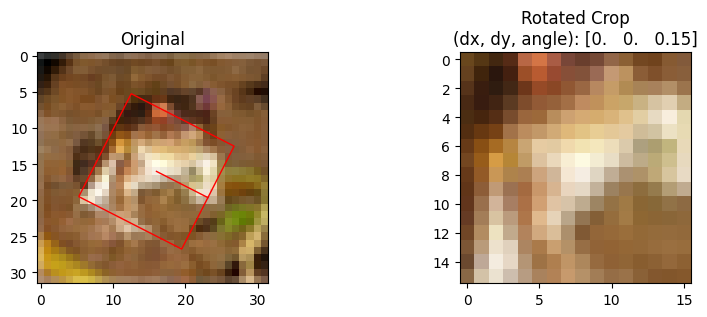

In [5]:
# image manipulation function
def rotated_crop(image, dx, dy, da):
    """
    Takes a 50% crop of the source image after applying a positional and angular
    offset relative to the image's centre.
    For example, (dx,dy,da) = (-0.25,0,0.5) will take a crop centred one quarter
    of the image width to the left from the source image centre and rotated
    45 degrees (50% of 180 in whichever direction the positive direction happens
    to take).
    Args:
      image: source image
      dx: float in range -0.5 .. +0.5 (fraction of width)
      dy: float in range -0.5 .. +0.5 (fraction of height)
      da: float in range -1.0 .. +1.0 (fraction of radians)
    Returns:
      cropped image
    """
    # Image dimensions
    img_height, img_width = image.shape[0], image.shape[1]
    img_centre_x = img_width // 2
    img_centre_y = img_height // 2
    crop_size = img_height // 2  # 50% of original size (16x16 for CIFAR-10)
    crop_centre_x = crop_size // 2
    crop_centre_y = crop_size // 2

    # Step 1: Rotate crop window about its top-left corner
    # - assuming crop-mid is at (x,y)=(8,8)
    # - net result is that the crop-mid will move to crop_mid' = tf.linalg.matvec(R, crop_mid)
    R = tf.stack([
        [tf.cos(da * np.pi), -tf.sin(da * np.pi), 0],
        [tf.sin(da * np.pi), tf.cos(da * np.pi), 0],
        [0.0, 0.0, 1.0]
    ])
    R_neg = tf.stack([
        [tf.cos(-da * np.pi), -tf.sin(-da * np.pi), 0],
        [tf.sin(-da * np.pi), tf.cos(-da * np.pi), 0],
        [0.0, 0.0, 1.0]
    ])

    # Step 2a: Calculate crop-mid after rotation
    crop_mid = [crop_centre_x, crop_centre_y, 1.]
    crop_mid = tf.linalg.matvec(R, crop_mid)

    # Step 2b: Translate rotated location of crop-mid back to it's original position
    Tv = [crop_centre_x - crop_mid[0], crop_centre_y - crop_mid[1], 1.]

    # Step 2c: translate crop-mid to target location on source image
    tx = img_centre_x + dx * img_width - crop_centre_x
    ty = img_centre_y + dy * img_height - crop_centre_y
    Tv = [Tv[0] + tx, Tv[1] + ty, 1.]

    # Step 2d: reverse rotation impact before applying
    # - we'll apply the translation first, so it's ultimate effect is then rotated,
    #   so we counteract that effect by pre-rotating in the opposite direction
    Tv = tf.linalg.matvec(R_neg, Tv)
    T = tf.stack([
        [1.0, 0.0, Tv[0]],
        [0.0, 1.0, Tv[1]],
        [0.0, 0.0, 1.0]
    ])

    # combine transformations: R * T
    # - technically this is applying T first, and then R
    # - has effect of rotating crop window by R, and then translating by R(T)
    h_matrix = tf.linalg.matmul(R, T)

    # Flatten to 8 parameters (last is 1)
    h_matrix = tf.reshape(h_matrix, [-1])[:-1]

    # Apply projective transform
    rotated_crop = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),  # Add batch dimension
        transforms=tf.expand_dims(h_matrix, 0),  # Add batch dimension
        output_shape=[crop_size, crop_size],
        interpolation='BILINEAR',
        fill_value=0.0,
        fill_mode='CONSTANT'
    )[0]  # Remove batch dimension

    return rotated_crop

def draw_crop_template(image, transform):
  dx, dy, da = transform
  centre_x = image.shape[1] * (0.5 + dx)
  centre_y = image.shape[0] * (0.5 + dy)
  width = image.shape[1] // 2
  height = image.shape[0] // 2
  radians = da * np.pi

  # draw a rectangle showing the outline of where the crop was taken from
  ax = plt.gca()
  rect = patches.Rectangle((centre_x - width/2, centre_y - height/2), width, height, linewidth=1, edgecolor='r', facecolor='none')
  t = transforms.Affine2D().rotate_deg_around(centre_x, centre_y, radians * 180 / np.pi)
  rect.set_transform(t + ax.transData)
  ax.add_patch(rect)

  # draw a rotated 0-degrees line to indicate the rotation.
  line_end_x = centre_x + width / 2
  line_end_y = centre_y
  rotated_endpoint = t.transform([(line_end_x, line_end_y)])[0]
  ax.plot([centre_x, rotated_endpoint[0]], [centre_y, rotated_endpoint[1]], color='r', linewidth=1)

def show_data_sample(inputs, output):
  (image, cropped) = inputs
  transform = output
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.title("Original")
  plt.imshow(image)
  draw_crop_template(image, transform)

  plt.subplot(1, 2, 2)
  plt.title(f"Rotated Crop\n(dx, dy, angle): {transform}")
  plt.imshow(cropped)
  plt.show()

image = x_train[0]
transform = tf.constant(([0.0, 0.0, 0.15]))
cropped = rotated_crop(image, dx=transform[0], dy=transform[1], da=transform[2])
show_data_sample((image, cropped), transform)

Original shape: (32, 32, 32, 3)
Rotated Crop shape: (32, 16, 16, 3)
Transformation shape: (32, 3)


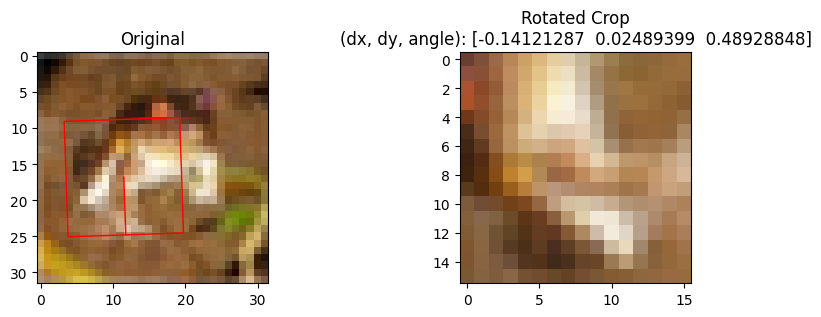

Time for 100 batches: 0.71 seconds
Total batches: 1563


In [6]:
# pre-processing pipeline
def preprocess_image(image):
    # Generate random translation and rotation
    # - dx/dy in range -0.5..+0.5 (fraction of width/height)
    # - da    in range -1.0..+1.0 (radians)
    # - small stddev
    dx = tf.clip_by_value(tf.random.normal([], mean=0, stddev=0.5/4), -0.5, 0.5)
    dy = tf.clip_by_value(tf.random.normal([], mean=0, stddev=0.5/4), -0.5, 0.5)
    da = tf.clip_by_value(tf.random.normal([], mean=0, stddev=1.0/4), -1.0, 1.0)

    # Take rotated crop
    cropped = rotated_crop(image, dx, dy, da)

    # construct as input/output tuples
    transform = tf.stack([dx, dy, da])
    return (image, cropped), transform

def prepared_dataset():
  train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
  train_dataset = train_dataset.map(
      preprocess_image,
      num_parallel_calls=tf.data.AUTOTUNE
  )
  return train_dataset

# Create the dataset pipeline
train_dataset = prepared_dataset().batch(32).prefetch(tf.data.AUTOTUNE)

# Test and visualize
for (original, cropped), transform in train_dataset.take(1):
    print("Original shape:", original.shape)         # [batch, 32, 32, 3]
    print("Rotated Crop shape:", cropped.shape) # [batch, 16, 16, 3]
    print("Transformation shape:", transform.shape)  # [batch, 3]

    show_data_sample((original[0], cropped[0]), transform[0])

# Optional: Time the pipeline
import time
start = time.time()
for _ in train_dataset.take(100):  # Process 100 batches
    pass
print(f"Time for 100 batches: {time.time() - start:.2f} seconds")
print(f"Total batches: {len(train_dataset)}")

## Model


In [10]:
# CoordConv layer
# Based on R. Liu et al., “An Intriguing Failing of CNNs and the CoordConv Solution,” NeurIPS 2018
# https://arxiv.org/abs/1807.03247
class CoordConv(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # inputs.shape => [batch_size, height, width, channels]
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))

        # Generate a coordinate grid:
        # - x_coords: shape (width,) from -0.5 to 0.5
        # - y_coords: shape (height,) from -0.5 to 0.5
        x_coords = tf.linspace(-0.5, 0.5, width)
        y_coords = tf.linspace(-0.5, 0.5, height)

        # Use meshgrid to get 2D coordinate maps
        # - xx, yy shape => (height, width)
        xx, yy = tf.meshgrid(x_coords, y_coords)

        # Reshape for appending as channels
        xx = tf.expand_dims(xx, axis=-1)  # (height, width, 1)
        yy = tf.expand_dims(yy, axis=-1)  # (height, width, 1)

        # Tile across batch dimension
        xx_tiled = tf.tile(tf.expand_dims(xx, 0), [batch_size, 1, 1, 1])
        yy_tiled = tf.tile(tf.expand_dims(yy, 0), [batch_size, 1, 1, 1])

        # Concatenate to inputs along the channel dimension
        # outputs.shape => [batch_size, height, width, channels+2]
        output = tf.concat([inputs, xx_tiled, yy_tiled], axis=-1)
        return output

input = tf.keras.Input(shape=(32, 32, 3))
cc = CoordConv()(input)
cc.shape

(None, 32, 32, 5)

In [15]:
def coord_xform_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv()(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv_1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv_2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv_3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv_4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv_5')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape1')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv()(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv_1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv_2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv_3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv_4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv_5')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape1')(x2)

    # Prepare for cross-attention
    # - we re-use the same transformation for feature descriptors, and another shared transformation
    #   for spatial descriptors. 'transform' in the generic sense, not the model-architecture.
    feature_xformer = layers.Dense(units=16, activation='relu', name='feature_xformer')
    spatial_xformer = layers.Dense(units=16, activation='relu', name='spatial_xformer')
    x1_features = feature_xformer(x1)
    x2_features = feature_xformer(x2)
    x1_spatial = spatial_xformer(x1)
    x2_spatial = spatial_xformer(x2)

    # Cross-attention
    #   - query/key = feature descriptors on x2 and x1, respectively
    #   - value     = spatial descriptor from x1
    #   - result    = x1 spatial values mapped per-pixel onto x2,
    #        ie: nominally, for each x2 pixel, this holds the location of that pixel in x1
    x1_spatial_by_x2 = layers.MultiHeadAttention(num_heads=4, key_dim=16, value_dim=16, output_shape=16, name='mhe1')(
        query=x2_features, key=x1_features, value=x1_spatial)

    # Compute per-pixel local translations
    # - reshape each back to (height, width, channels)
    # - nominally, combine and comopute relative transformations (dx, dy) for each pixel individually
    # - solve for global alignment (alternative would be an iterative least-squares fit)
    # - 256x16 + 256x16 -> 16x16x16 + 16x16x16 -> 8x8x32 -> 4x4x64 -> 2x2x128 -> 1x1x64 -> 64 -> 3
    # - uses avg-pooling instead of max-pooling because nominally the features are linear euclidean coordinates
    x1_spatial_by_x2 = layers.Reshape((16, 16, -1), name='x1_reshape2')(x1_spatial_by_x2)
    x2_spatial = layers.Reshape((16, 16, -1), name='x2_reshape2')(x2_spatial)
    x = layers.Concatenate(name='head_concat')([x1_spatial_by_x2, x2_spatial])
    x = layers.Conv2D(filters=32, kernel_size=1, activation='relu', name='head_conv_1a')(x)
    x = layers.Conv2D(filters=32, kernel_size=1, activation='relu', name='head_conv_1b')(x)
    x = layers.AvgPool2D(pool_size=2, name='head_pool1')(x)
    x = layers.Conv2D(filters=64, kernel_size=1, activation='relu', name='head_conv_2a')(x)
    x = layers.Conv2D(filters=64, kernel_size=1, activation='relu', name='head_conv_2b')(x)
    x = layers.AvgPool2D(pool_size=2, name='head_pool2')(x)
    x = layers.Conv2D(filters=128, kernel_size=1, activation='relu', name='head_conv_3a')(x)
    x = layers.Conv2D(filters=128, kernel_size=1, activation='relu', name='head_conv_3b')(x)
    x = layers.AvgPool2D(pool_size=2, name='head_pool3')(x)
    x = layers.Conv2D(filters=64, kernel_size=1, activation='relu', name='head_conv_4a')(x)
    x = layers.Conv2D(filters=64, kernel_size=1, activation='relu', name='head_conv_4b')(x)
    x = layers.AvgPool2D(pool_size=2, name='head_pool4')(x)
    x = layers.Flatten(name="head_flatten")(x)
    x = layers.Dense(3, activation='relu', name='head_dense1')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
coord_xform_model().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coord_conv_9 (CoordConv)  │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coord_conv_10 (CoordConv) │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv_1 (Conv2D)        │ (None, 32, 32, 8)      │            368 │ coord_conv_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv_1 (Conv2D)        │ (None, 16, 16, 8)      │            368 │ coord_conv_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv_2 (Conv2D)        │ (None, 32, 32, 16)     │          1,168 │ x1_conv_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv_2 (Conv2D)        │ (None, 16, 16, 16)     │          1,168 │ x2_conv_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv_3 (Conv2D)        │ (None, 32, 32, 32)     │          4,640 │ x1_conv_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv_3 (Conv2D)        │ (None, 16, 16, 32)     │          4,640 │ x2_conv_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv_4 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ x1_conv_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv_4 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ x2_conv_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv_5 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ x1_conv_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv_5 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ x2_conv_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape1 (Reshape)     │ (None, 1024, 128)      │              0 │ x1_conv_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape1 (Reshape)     │ (None, 256, 128)       │              0 │ x2_conv_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_xformer (Dense)   │ (None, 256, 16)        │          2,064 │ x1_reshape1[0][0],     │
│                           │                        │                │ x2_reshape1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_xformer (Dense)   │ (None, 256, 16)        │          2,064 │ x1_reshape1[0][0],     │
│                           │                        │                │ x2_reshape1[0][0]      │
├──────────────────────

 Total params: 251,315 (981.70 KB)

 Trainable params: 251,315 (981.70 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model = coord_xform_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset().take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[tinstr.HistoryStats()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 0.0307
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0318
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0307
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0311
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0315
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0315
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0310
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0311
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0311
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0318
